# 데이터 로드 및 전력소비량 분리(train)

In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

train_data.head(), test_data.head(), sample_submission.head()

(   num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
 0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
 1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
 2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
 3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
 4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   
 
    일사(MJ/m2)  전력소비량(kWh)  
 0        NaN     1085.28  
 1        NaN     1047.36  
 2        NaN      974.88  
 3        NaN      953.76  
 4        NaN      986.40  ,
    num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
 0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
 1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
 2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
 3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
 4  

# SARIMA

- p: 자기회귀(AR)의 차수
- d: 차분의 차수
- q: 이동평균(MA)의 차수
- P: 계절성 자기회귀의 차수
- D: 계절성 차분의 차수
- Q: 계절성 이동평균의 차수
- S: 계절성 주기

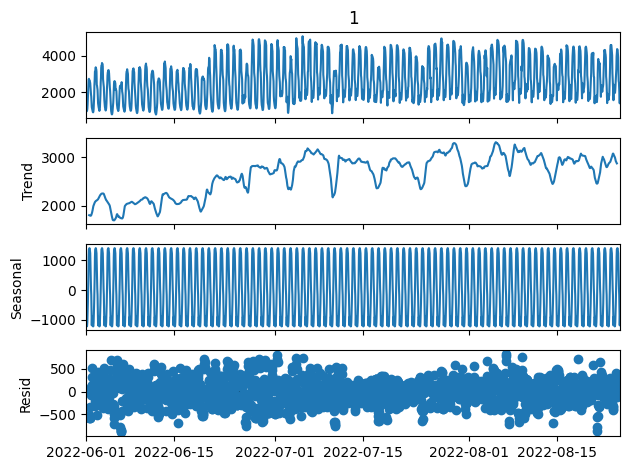

In [7]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 건물별로 전력소비량 시계열 데이터 추출
building_power_usage = train_data.pivot(index='일시', columns='건물번호', values='전력소비량(kWh)')

building_power_usage.index = pd.to_datetime(building_power_usage.index)

# 첫 번째 건물의 전력소비량 시계열 데이터 선택
building_1_power_usage = building_power_usage[1]

# 인덱스를 날짜 형식으로 변환
building_1_power_usage.index = pd.to_datetime(building_1_power_usage.index)

# 시계열 분해 (추세, 계절성, 잔차) - 하루 주기로 계절성 분석
decomposition_building_1 = seasonal_decompose(building_1_power_usage, period=24)

# 시계열 분해 결과 그래프로 표현
fig_building_1 = decomposition_building_1.plot()
plt.show() 

- 하루 주기의 계절성이 명확하게 확인

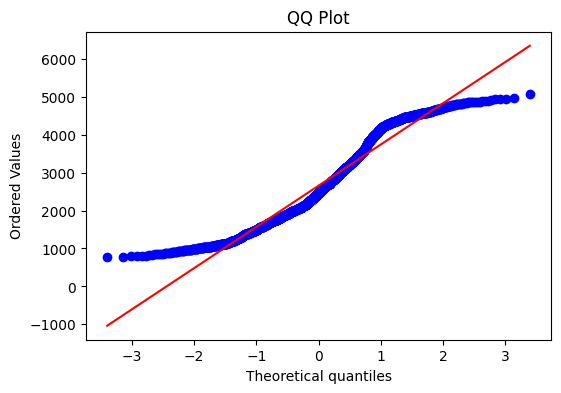

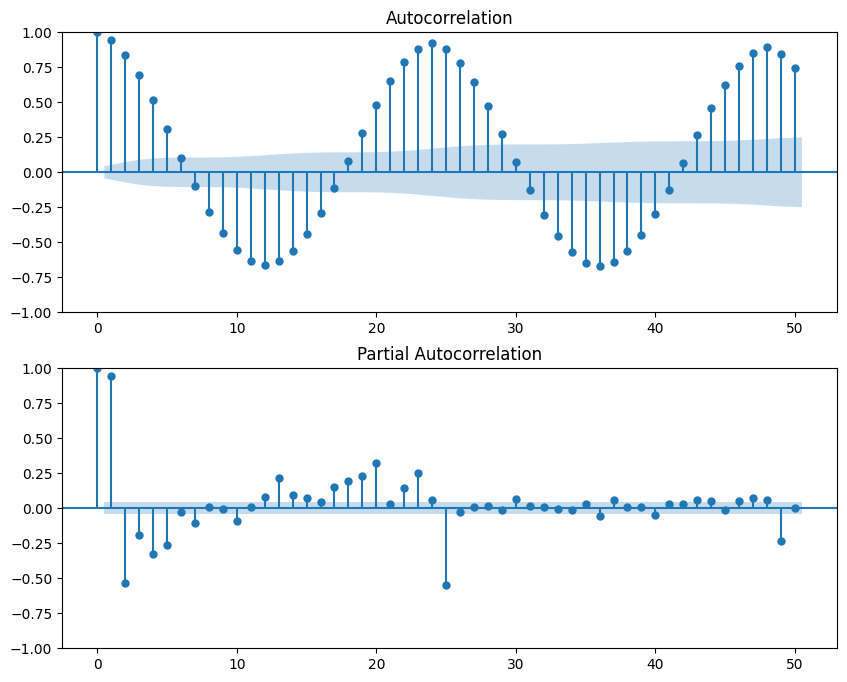


ADF Test Results:
ADF Statistic: -3.891436846726443
p-value: 0.0020987788592241674
Critical Values: {'1%': -3.4336010696328323, '5%': -2.8629761530066187, '10%': -2.567534545549574}
Is data stationary?: Yes

Homoscedasticity Test Results:
Bartlett Test p-value: 0.058713782247809036
Levene Test p-value: 0.7131960256937061
Equal variance? Yes


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import probplot, bartlett, levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class TimeSeriesTester:
    def __init__(self, data):
        self.data = data

    def plot_qq_plot(self):
        plt.figure(figsize=(6, 4))
        probplot(self.data, dist='norm', plot=plt)
        plt.title("QQ Plot")
        plt.show()

    def plot_acf_pacf(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(self.data, ax=ax1, lags=50)
        plot_pacf(self.data, ax=ax2, lags=50)
        plt.show()

    def test_stationarity(self):
        adf_result = adfuller(self.data)
        adf_test_results = {
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Critical Values": adf_result[4],
            "Is data stationary?": "Yes" if adf_result[1] <= 0.05 else "No"
        }
        print("\nADF Test Results:")
        for key, value in adf_test_results.items():
            print(f"{key}: {value}")

    def test_homoscedasticity(self):
        n = len(self.data)
        group1 = self.data[:n // 2]
        group2 = self.data[n // 2:]

        bartlett_result = bartlett(group1, group2)
        levene_result = levene(group1, group2)

        equal_variance = bartlett_result.pvalue > 0.05 and levene_result.pvalue > 0.05
        print("\nHomoscedasticity Test Results:")
        print("Bartlett Test p-value:", bartlett_result.pvalue)
        print("Levene Test p-value:", levene_result.pvalue)
        print("Equal variance?", "Yes" if equal_variance else "No")

# 클래스 인스턴스 생성 
tester = TimeSeriesTester(building_1_power_usage) # 첫 번째 건물 전기 사용량

tester.plot_qq_plot()
tester.plot_acf_pacf()
tester.test_stationarity()
tester.test_homoscedasticity()


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 설정 및 훈련
sarima_model_building_1 = SARIMAX(building_1_power_usage, order=(2, 1, 1), seasonal_order=(1, 1, 2, 24))
sarima_fit_building_1 = sarima_model_building_1.fit(disp=False)

c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
forecast_building_1 = sarima_fit_building_1.get_forecast(steps=7*24)
forecast_values_building_1 = forecast_building_1.predicted_mean
forecast_values_building_1

2022-08-25 00:00:00    1911.190927
2022-08-25 01:00:00    1845.755537
2022-08-25 02:00:00    1712.507165
2022-08-25 03:00:00    1653.332736
2022-08-25 04:00:00    1673.837302
                          ...     
2022-08-31 19:00:00    2833.100936
2022-08-31 20:00:00    2600.306512
2022-08-31 21:00:00    2102.999504
2022-08-31 22:00:00    1603.425096
2022-08-31 23:00:00    2148.850044
Freq: H, Name: predicted_mean, Length: 168, dtype: float64

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 건물별 예측 결과를 저장할 딕셔너리
forecast_values_all_buildings = {}

# 각 건물에 대해 SARIMA 모델 훈련 및 예측 
for building_num in building_power_usage.columns:
    building_power_usage_data = building_power_usage[building_num]

    # SARIMA 모델 설정 및 훈련
    sarima_model_building = SARIMAX(building_power_usage_data, order=(2, 1, 1), seasonal_order=(1, 1, 2, 24))
    sarima_fit_building = sarima_model_building.fit(disp=False)

    # 7일간 (7*24시간) 예측
    forecast_building = sarima_fit_building.get_forecast(steps=7*24)
    forecast_values_building = forecast_building.predicted_mean

    # 건물별 예측 결과 저장
    forecast_values_all_buildings[building_num] = forecast_values_building

# 예측 결과 확인
forecast_values_all_buildings

c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Pytho

LinAlgError: LU decomposition error.

- 해당 오류는 데이터의 역행렬이 성립되지 않아 생기는 문제로, 비정상성/높은 차수/과도히 큰 매개변수 공간에 의해 발생한다.

- 즉, 개별 건물의 전력사용량의 차수를 모두 고려하지 않아 발생하는 문제로 추정된다.

- 이 문제를 해결하기 위해서는 모든 건물의 차수를 고려하거나, 비슷한 건물들끼리 묶어서 차수를 돌려야 하지만 SARIMA 모델 자체가 나머지 feature들을 고려하지 않고 있기 때문에 굳이 더 이상 진행해보지 않고, 다음 모델로 넘어가는 것이 낫다고 판단했다.

# Auto-Arima

In [12]:
import pmdarima as pm

# 예측 결과 저장
forecast_values_all_buildings_auto_arima = {}

for building_num in building_power_usage.columns:
    building_power_usage_data = building_power_usage[building_num]

    # Auto-ARIMA로 최적의 SARIMA 모델 찾기
    sarima_model_building = pm.auto_arima(building_power_usage_data, seasonal=True, m=24, stepwise=True)

    # 7일간 (7*24시간) 예측
    forecast_values_building = sarima_model_building.predict(n_periods=7*24)

    # sample_submission DataFrame에 예측 결과 저장
    forecast_values_all_buildings_auto_arima[building_num] = forecast_values_building

forecast_values_all_buildings_auto_arima


c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,0,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
       

KeyboardInterrupt: 

- SARIMA와 동일 문제 발생하면서 무한 loop 발생

### VAR

In [13]:
building_power_usage

건물번호,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
일시,,,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,1085.28,1170.36,926.28,740.16,1304.64,934.56,560.16,1178.88,1278.72,3785.76,...,411.36,503.10,640.62,1134.24,681.48,1576.68,774.36,533.52,642.96,372.00
2022-06-01 01:00:00,1047.36,1146.96,884.52,671.04,1308.24,885.12,563.28,1173.84,1047.36,3867.84,...,401.76,480.06,576.18,1101.36,999.72,1558.68,553.86,516.78,603.36,333.36
2022-06-01 02:00:00,974.88,1115.28,882.36,619.20,1302.48,882.24,541.68,1115.04,998.88,3972.48,...,400.56,468.18,561.96,1090.32,806.40,1413.36,558.90,509.40,581.22,320.64
2022-06-01 03:00:00,953.76,1107.00,867.24,626.40,1295.28,855.84,526.56,1082.40,962.40,3976.80,...,406.32,463.50,574.20,1066.32,741.60,1483.92,559.44,479.70,599.94,311.04
2022-06-01 04:00:00,986.40,1069.92,880.92,626.22,1316.88,842.40,532.32,1202.40,972.96,3855.36,...,417.36,473.94,564.30,1079.04,897.84,1438.56,559.62,541.98,595.62,312.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24 19:00:00,2517.12,1866.96,2729.16,847.08,1776.24,1955.52,906.24,1366.32,2771.04,3816.96,...,2255.04,1723.86,1310.40,2772.96,1446.12,3164.16,1250.64,1107.00,1299.24,881.04
2022-08-24 20:00:00,2208.96,1693.80,2664.00,782.10,1675.44,1934.88,831.60,1361.04,2644.32,3684.00,...,1906.32,1617.12,1272.24,2594.64,836.64,2977.68,1184.58,1053.18,1276.92,798.96
2022-08-24 21:00:00,1806.24,1564.92,2135.16,751.86,1604.88,1825.92,612.96,1323.84,2378.40,3467.04,...,1236.48,1420.74,1204.92,2210.16,813.96,2875.44,1151.28,971.82,1062.00,825.12


In [14]:
from statsmodels.tsa.api import VAR
from datetime import datetime

# VAR 모델에 대한 최적의 차수 선택
var_model = VAR(building_power_usage)
optimal_lag_order = var_model.select_order().selected_orders['aic']

# 최적의 차수로 VAR 모델 훈련
var_model_fitted = var_model.fit(optimal_lag_order)

# 7일간 (7*24시간) 예측
forecast_values_var = var_model_fitted.forecast(building_power_usage.values[-optimal_lag_order:], steps=7*24)


c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:2300: RuntimeWarning: overflow encountered in exp
  fpe = ((nobs + self.df_model) / self.df_resid) ** neqs * np.exp(ld)
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:2300: RuntimeWarning: overflow encountered in scalar multiply
  fpe = ((nobs + self.df_model) / self.df_resid) ** neqs * np.exp(ld)


In [44]:
sample_submission['answer'] = forecast_values_var.flatten()
sample_submission

,num_date_time,answer
0,1_20220825 00,2523.245526
1,1_20220825 01,1291.965359
2,1_20220825 02,-44.267363
3,1_20220825 03,693.218021
4,1_20220825 04,4231.964052
...,...,...
16795,100_20220831 19,-6152.900104
16796,100_20220831 20,-642.593808
16797,100_20220831 21,-344.911148
16798,100_20220831 22,1337.875693


- 말도 안되는 결과가 나옴을 확인

- feature를 고려하지 않는 ARIMA 계열 모델은 해당 data에서 사용하기 힘들다고 판단

- ML 계열 모델로 변경 요망